In [18]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [19]:
%matplotlib inline

In [2]:
gdf = gpd.read_file('DTM80/DTM_80m.shp')
gdf.head()

,pointid,grid_code,geometry
0,1,6.88647,POINT (677037.000 749997.000)
1,2,5.92721,POINT (677117.000 749997.000)
2,3,5.96078,POINT (677197.000 749997.000)
3,4,6.43263,POINT (677277.000 749997.000)
4,5,6.91049,POINT (677357.000 749997.000)


In [3]:
gdf.crs

<Derived Projected CRS: EPSG:3812>
Name: ETRS89 / Belgian Lambert 2008
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Belgium - onshore.
- bounds: (2.5, 49.5, 6.4, 51.51)
Coordinate Operation:
- name: Belgian Lambert 2008
- method: Lambert Conic Conformal (2SP)
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [4]:
gdf = gdf.to_crs(31370)
gdf.head()

,pointid,grid_code,geometry
0,1,6.88647,POINT (177047.057 249994.013)
1,2,5.92721,POINT (177127.057 249994.004)
2,3,5.96078,POINT (177207.058 249993.994)
3,4,6.43263,POINT (177287.059 249993.985)
4,5,6.91049,POINT (177367.059 249993.975)


In [5]:
gdf = gdf.to_crs(3812)
gdf.head()

,pointid,grid_code,geometry
0,1,6.88647,POINT (677037.000 749997.000)
1,2,5.92721,POINT (677117.000 749997.000)
2,3,5.96078,POINT (677197.000 749997.000)
3,4,6.43263,POINT (677277.000 749997.000)
4,5,6.91049,POINT (677357.000 749997.000)


In [40]:
gdf['x'] = gdf.geometry.apply(lambda g: g.x)
gdf['y'] = gdf.geometry.apply(lambda g: g.y)
gdf.rename(columns={'pointid': 'point_id', 'grid_code': 'z'}, inplace=True)
gdf.head()

,point_id,z,geometry,x,y,slope_x
0,1,6.88647,POINT (677037.000 749997.000),677036.999713,749997.000262,677035.999713
1,2,5.92721,POINT (677117.000 749997.000),677116.999713,749997.000262,80.000000
2,3,5.96078,POINT (677197.000 749997.000),677196.999713,749997.000262,80.000000
3,4,6.43263,POINT (677277.000 749997.000),677276.999713,749997.000262,80.000000
4,5,6.91049,POINT (677357.000 749997.000),677356.999713,749997.000262,80.000000


In [41]:
y = gdf['y'].to_numpy()
diff_y = np.diff(y, prepend=0)


In [42]:
indices = np.where(np.abs(diff_y) > 1)[0]
print(indices)

[      0      25      50 ... 5303717 5303767 5303817]


In [31]:
gdf.loc[indices[1], 'y'] - gdf.loc[indices[0], 'y']

-79.99999998509884

In [74]:
z = gdf.z.to_numpy()
slope_x = np.diff(z, append=(z[-1] + (z[-1] - z[-2]))) / 80
print(slope_x[-2:])

[-0.1303375 -0.1303375]


In [75]:
diff_indices = np.diff(indices, append=gdf.shape[0]-1)
diff_indices[-1]

49

In [82]:
slope_y = np.zeros((gdf.shape[0],))
for i in range(indices.shape[0] - 1):
    for j in range(diff_indices[i]):
        k = indices[i] + j
        slope_y[k] = (z[k] - z[k + diff_indices[i]]) / 80
slope_y[-50:] = slope_y[-100:-50]

In [83]:
gdf['slope_x'] = slope_x
gdf['slope_y'] = slope_y

In [85]:
from osgeo import gdal

In [86]:
tif = gdal.Open('DTM20/DTM_20m1.tif', gdal.GA_ReadOnly)

In [187]:
geo_transform = tif.GetGeoTransform()
x0 = geo_transform[0]
y0 = geo_transform[3]
dx = geo_transform[1]
dy = geo_transform[5]

def get_index(x, y):
    i = np.round((x - x0) / dx).astype(int)
    j = np.round((y - y0) / dy).astype(int)
    return i, j

In [247]:
band = tif.GetRasterBand(1)
img_as_array = band.ReadAsArray()
img_as_array.shape

(11503, 13955)

In [248]:
min_z = np.min(img_as_array)
img_as_array[img_as_array <= 0.1 * min_z] = np.nan

In [249]:
print(x0)
print(gdf.x.min())
print(y0)
print(gdf.y.max())

516917.0
517036.9997529518
750037.0
749997.000261768


In [250]:
# Test values
x_s, y_s, z_s = gdf.loc[gdf.shape[0] - 1, ['x', 'y', 'z']]
i_s, j_s = get_index(x_s, y_s)
z_array = img_as_array[j_s + 1, i_s]
print(f"From shp: {z_s}, from tif: {z_array}")

From shp: 199.969, from tif: 200.87127685546875


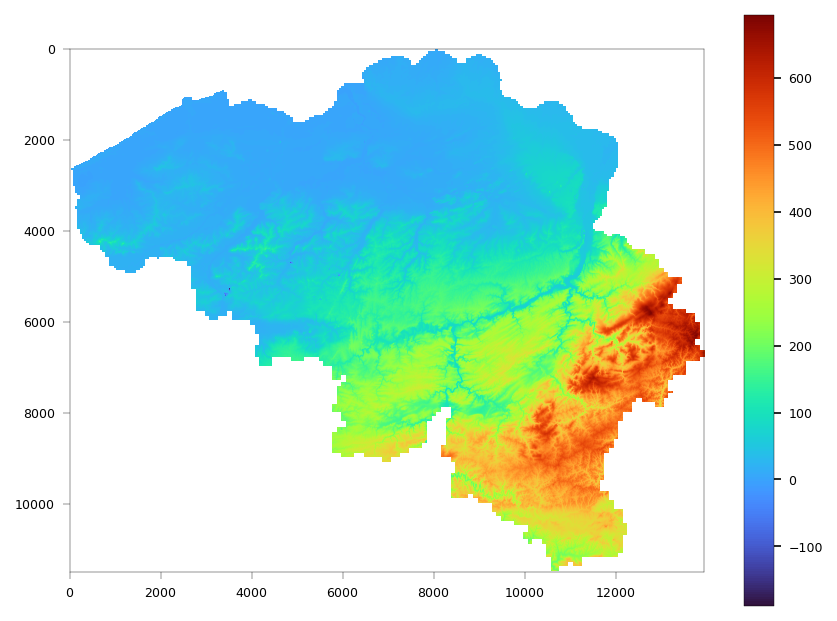

In [251]:
fig, ax = plt.subplots(figsize=(1024 / 150, 768 / 150), dpi=150)
plt.rcParams.update({'font.size': 6, 'axes.linewidth': 0.2})
im = ax.imshow(img_as_array, cmap='turbo')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
ax.tick_params(width=0.2)
plt.colorbar(im, ax=ax)
plt.savefig('dtm.pdf', format='pdf')

In [266]:
slope_x_img = np.diff(img_as_array, axis=1) / 20
slope_x_img = np.hstack([slope_x_img[:, [0]], slope_x_img])
slope_y_img = np.flip(np.diff(np.flip(img_as_array, axis=0), axis=0), axis=0) / 20
slope_y_img = np.vstack([slope_y_img, slope_y_img[[-1], :]])

slope_mag_img = np.sqrt(slope_x_img ** 2 + slope_y_img ** 2)
slope_max_abs = np.maximum(np.abs(slope_x_img), np.abs(slope_y_img))

print(img_as_array.shape)
print(slope_x_img.shape)
print(slope_y_img.shape)

(11503, 13955)
(11503, 13955)
(11503, 13955)


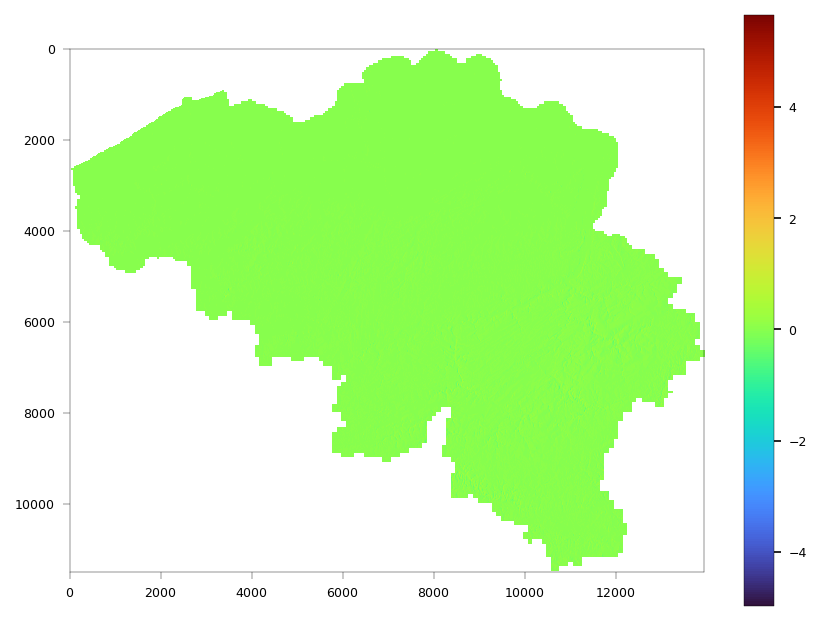

In [260]:
fig, ax = plt.subplots(figsize=(1024 / 150, 768 / 150), dpi=150)
im = ax.imshow(slope_x_img, cmap='turbo')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
ax.tick_params(width=0.2)
plt.colorbar(im, ax=ax)
#plt.savefig('slope_x_img.pdf', format='pdf')

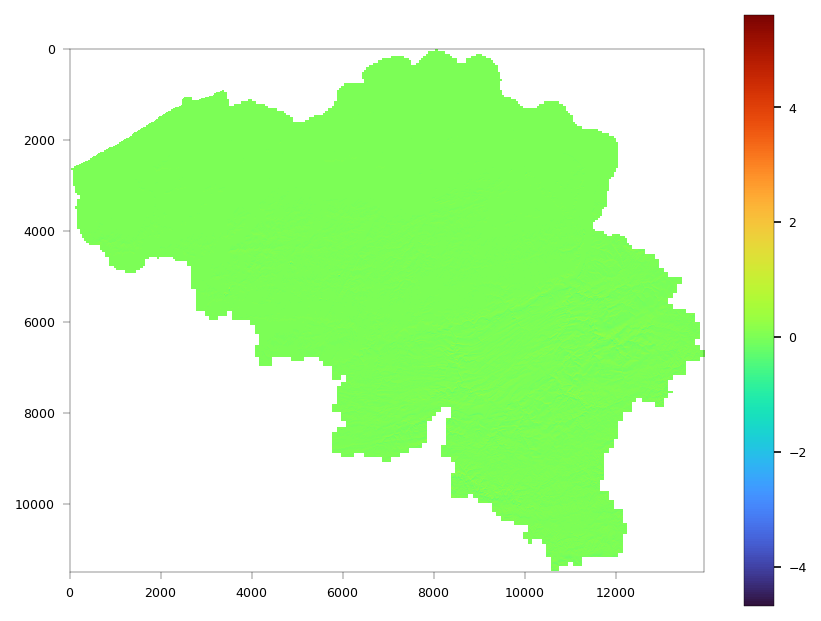

In [261]:
fig, ax = plt.subplots(figsize=(1024 / 150, 768 / 150), dpi=150)
im = ax.imshow(slope_y_img, cmap='turbo')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
ax.tick_params(width=0.2)
plt.colorbar(im, ax=ax)
plt.savefig('slope_y_img.pdf', format='pdf')

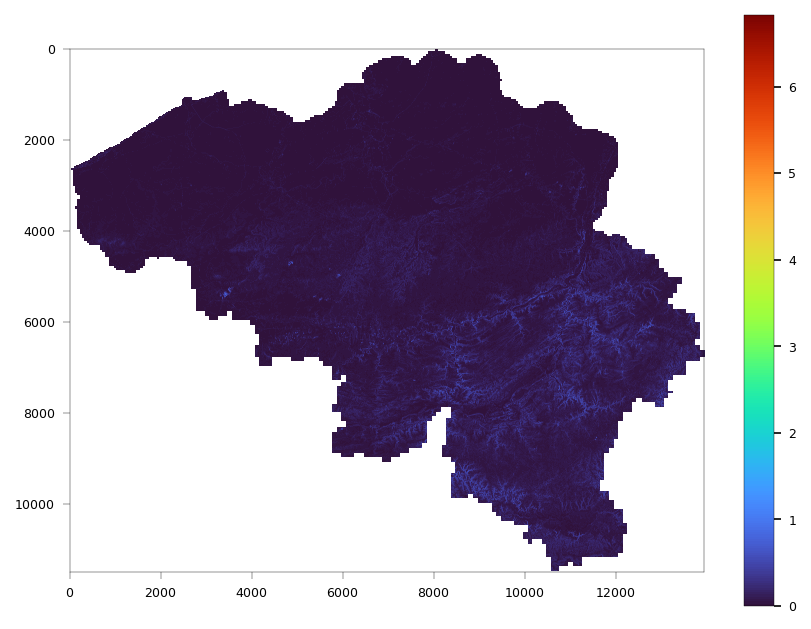

In [264]:
fig, ax = plt.subplots(figsize=(1024 / 150, 768 / 150), dpi=150)
im = ax.imshow(slope_mag_img, cmap='turbo')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
ax.tick_params(width=0.2)
plt.colorbar(im, ax=ax)
plt.savefig('slope_mag_img.pdf', format='pdf')

In [265]:
print(np.nanmin(slope_mag_img))
print(np.nanmax(slope_mag_img))

0.0
6.8305464


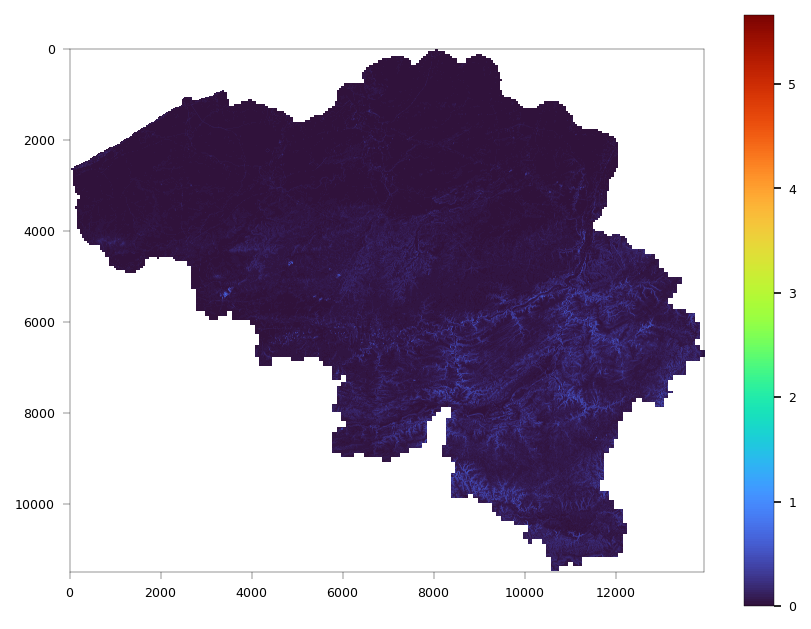

In [267]:
fig, ax = plt.subplots(figsize=(1024 / 150, 768 / 150), dpi=150)
im = ax.imshow(slope_max_abs, cmap='turbo')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
ax.tick_params(width=0.2)
plt.colorbar(im, ax=ax)
plt.savefig('slope_max_abs_img.pdf', format='pdf')